In [1]:
# default_exp core

# Few-shot Learning with GPT-J

> API details.

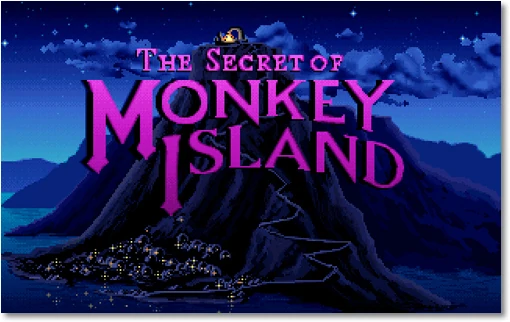

In [120]:
# export
import os
import pandas as pd

In [113]:
#hide
from nbdev.showdoc import *
import toml
s = toml.load("../.streamlit/secrets.toml", _dict=dict)

Using `GPT_J` model API from [Nlpcloud](https://nlpcloud.io/home/token)

In [15]:
import nlpcloud
client = nlpcloud.Client("gpt-j", s['nlpcloud_token'], gpu=True)

In [44]:
# example API call
generation = client.generation("""Insult: You fight like a dairy Farmer!
            Comeback: How appropriate. You fight like a cow!
            ###
            Insult: This is the END for you, you gutter crawling cur!
            Comeback: And I've got a little TIP for you, get the POINT?
            ###
            Insult: I've spoken with apes more polite than you!
            Comeback: I'm glad to hear you attended your family reunion!
            ###
            Insult: Soon you'll be wearing my sword like a shish kebab!
            Comeback: First you'd better stop waving it like a feather duster.
            ###
            Insult: I once owned a dog that was smarter than you.
            Comeback: """,
    max_length=100,
    length_no_input=True,
    end_sequence="\n###",
    remove_input=True)

print('\n🔥🔥🔥 ', generation["generated_text"])

🔥🔥🔥  I hope you lost him.



## 📙 Insult Database
From Monkey Island fandom wiki.  
https://monkeyisland.fandom.com/wiki/Insult_Sword_Fighting

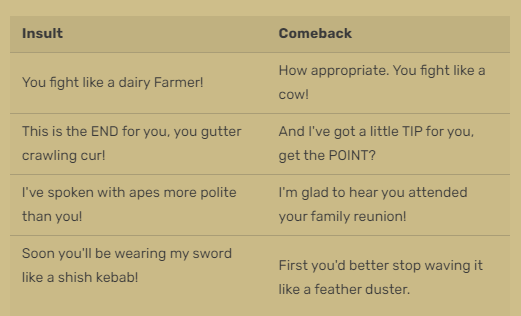

In [114]:
tb = pd.read_html("https://monkeyisland.fandom.com/wiki/Insult_Sword_Fighting")
pirate = tb[0]
master = tb[1] 

df = pirate
df.head()

,Insult,Comeback
0,You fight like a dairy Farmer!,How appropriate. You fight like a cow!
1,"This is the END for you, you gutter crawling cur!","And I've got a little TIP for you, get the POINT?"
2,I've spoken with apes more polite than you!,I'm glad to hear you attended your family reun...
3,Soon you'll be wearing my sword like a shish k...,First you'd better stop waving it like a feath...
4,People fall at my feet when they see me coming!,Even BEFORE they smell your breath?


In [119]:
#export
import os

def get_insult_data():
    """
    Scrape insult/comeback data from Monkey Island fandom wiki
    """
    dpath = 'data/insults.csv'
    if os.path.exists(dpath):
        pirate = pd.read_csv(dpath, index_col=0)
    else:
        tb = pd.read_html("https://monkeyisland.fandom.com/wiki/Insult_Sword_Fighting")
        pirate, master = tb[0], tb[1]
        pirate.to_csv(dpath)
    return pirate


In [118]:
df = get_insult_data()
df.head(3)

,Insult,Comeback
0,You fight like a dairy Farmer!,How appropriate. You fight like a cow!
1,"This is the END for you, you gutter crawling cur!","And I've got a little TIP for you, get the POINT?"
2,I've spoken with apes more polite than you!,I'm glad to hear you attended your family reun...


##  ⚔️ Generate Swordfight

In [76]:
# export

def create_input_string(insult, df, training_examples=5, intro=False):
    """
    Loops through insult database and creates few-shot learning string
        Skips over input insult/comeback in database
    """
    if intro: s = "The following is an insult battle between two pirates. \n###\n"
    else: s = ""
        
    for i in range(training_examples):
        if df.Insult[i] == insult: # add example from end of pack
            i = training_examples + 1 
        s += f"""Insult: {df.Insult[i]}\nComeback: {df.Comeback[i]}\n###\n"""
    
    return f"{s}Insult: {insult}\nComeback:"


In [77]:
t = create_input_string("People fall at my feet when they see me coming!", df, training_examples=3)
print(t)

Insult: You fight like a dairy Farmer!
Comeback: How appropriate. You fight like a cow!
###
Insult: This is the END for you, you gutter crawling cur!
Comeback: And I've got a little TIP for you, get the POINT?
###
Insult: I've spoken with apes more polite than you!
Comeback: I'm glad to hear you attended your family reunion!
###
Insult: People fall at my feet when they see me coming!
Comeback:


In [137]:
# export

def generate_comeback(insult, client, df, outputs, training_examples=3):
    """
    Creates input string and sends to nlpcloud for few-shot learning
    """
    print(f'Insult: ☠️ {insult} ☠️\n')
    t = create_input_string(insult, df, training_examples)
    zingers = []
    for i in range(outputs):
        generation = client.generation(t,
            max_length=100,
            length_no_input=True,
            end_sequence="\n###",
            remove_input=True)
        comeback = generation["generated_text"].strip('\n')
        print(f"Comeback: ({i}) {comeback} 🔥🔥🔥\n")
        zingers.append(comeback)
    return zingers


### Zinger Generation ⚓

In [79]:
generate_comeback('Every word you say to me is stupid.', client=client, df, outputs=3, training_examples=6)

Insult: ☠️ Every word you say to me is stupid.

Comeback: (0)  Is that right? I'll tell you something even stupider. 🔥🔥🔥

Comeback: (1)  You have a mouth full of CRAP! 🔥🔥🔥

Comeback: (2)  Every one of your sentences is complete and total BULLSHIT! 🔥🔥🔥



In [131]:
generate_comeback('Why are you such a stupid dumb idiot?', client=client, outputs=1, training_examples=9)

Insult: ☠️ Why are you such a stupid dumb idiot? ☠️

Comeback: (0)  Because you are, that's why! 🔥🔥🔥



In [74]:
generate_comeback("Heaven preserve me! You look like something that's died!", client, outputs=3, training_examples=15)

Insult: ☠️ Heaven preserve me! You look like something that's died!

Comeback: (0)  You don't say! It's too bad you didn't have a mirror. 🔥🔥🔥

Comeback: (1)  I was in a hurry to see if I'd got any mail. 🔥🔥🔥

Comeback: (2)  You could use some fresh air. 🔥🔥🔥



In [140]:
# API Cost PAYG @ nlpcloud.io
gpu_api_calls = 182
tokens_generated = 417
print(f'${gpu_api_calls * 0.001 + 0.0001 * tokens_generated}')

$0.2237
